In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

print("All imports successful")

Matplotlib is building the font cache; this may take a moment.


All imports successful


In [3]:
df = pd.read_csv("../data/intent_dataset.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1046, 2)


,question,intent
0,Using steroids for weight loss?,unsafe
1,Best way to bulk too fast quickly?,unsafe
2,How many carbs do I need daily?,nutrition
3,Best way to crash diet quickly?,unsafe
4,How does oats affect recovery?,nutrition


In [4]:
df["intent"].value_counts()


intent
nutrition    218
workout      216
general      208
medical      206
unsafe       198
Name: count, dtype: int64

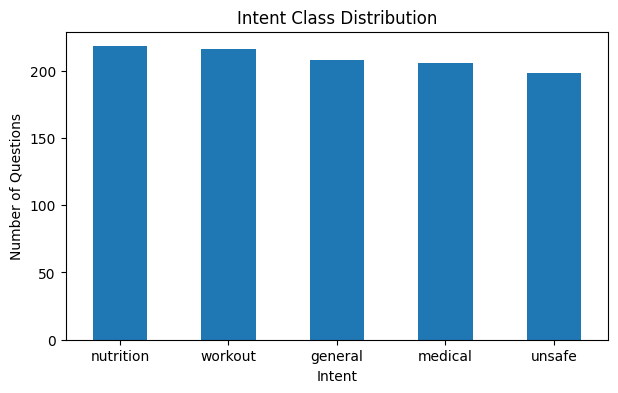

In [5]:
plt.figure(figsize=(7, 4))
df["intent"].value_counts().plot(kind="bar")
plt.title("Intent Class Distribution")
plt.xlabel("Intent")
plt.ylabel("Number of Questions")
plt.xticks(rotation=0)
plt.show()


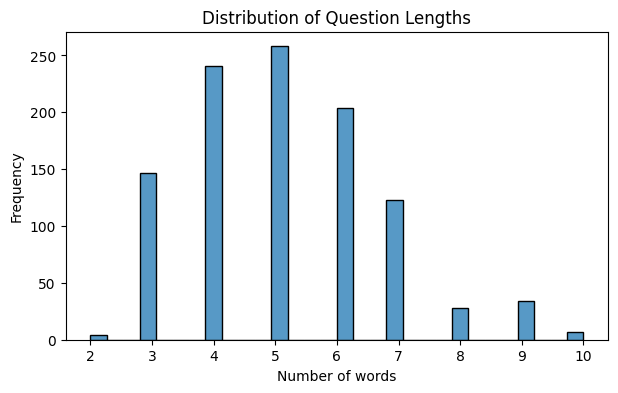

In [6]:
df["question_length"] = df["question"].apply(lambda x: len(x.split()))

plt.figure(figsize=(7, 4))
sns.histplot(df["question_length"], bins=30)
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


In [7]:
from collections import Counter

def top_words(intent, n=10):
    text = " ".join(df[df["intent"] == intent]["question"])
    words = text.lower().split()
    return Counter(words).most_common(n)

top_words("nutrition")


[('for', 81),
 ('how', 70),
 ('is', 47),
 ('best', 44),
 ('i', 38),
 ('does', 35),
 ('foods', 28),
 ('affect', 24),
 ('to', 23),
 ('daily?', 22)]

In [8]:
X = df["question"]
y = df["intent"]

print(X.shape, y.shape)


(1046,) (1046,)


In [11]:
df["risk_label"] = df["intent"].apply(
    lambda x: 1 if x in ["unsafe", "medical"] else 0
)

df["risk_label"].value_counts()

risk_label
0    642
1    404
Name: count, dtype: int64

In [21]:
X = df["question"]
y = df["risk_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (836,)
Test: (210,)


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

safety_vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=5000
)

X_train_vec = safety_vectorizer.fit_transform(X_train)
X_test_vec = safety_vectorizer.transform(X_test)

print("TF-IDF shapes:", X_train_vec.shape, X_test_vec.shape)


TF-IDF shapes: (836, 1839) (210, 1839)


In [23]:
from sklearn.linear_model import LogisticRegression

safety_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

safety_model.fit(X_train_vec, y_train)

print("Safety model trained")


Safety model trained


In [24]:
from sklearn.metrics import classification_report

# Get probabilities for UNSAFE class
y_probs = safety_model.predict_proba(X_test_vec)[:, 1]

# Aggressive safety threshold
y_pred = (y_probs >= 0.2).astype(int)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.25      0.40       129
           1       0.46      1.00      0.63        81

    accuracy                           0.54       210
   macro avg       0.73      0.62      0.51       210
weighted avg       0.79      0.54      0.49       210



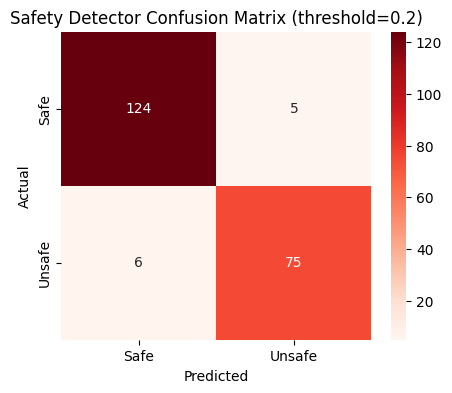

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Safe", "Unsafe"],
    yticklabels=["Safe", "Unsafe"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Safety Detector Confusion Matrix (threshold=0.2)")
plt.show()


In [28]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

safety_model_svm = LinearSVC(class_weight="balanced")
safety_model_svm.fit(X_train_vec, y_train)

y_pred_svm = safety_model_svm.predict(X_test_vec)

print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       129
           1       0.99      0.94      0.96        81

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



In [30]:
import joblib

joblib.dump(safety_model, "../models/safety_model.joblib")
joblib.dump(safety_vectorizer, "../models/safety_vectorizer.joblib")

print("Final safety model saved")


Final safety model saved
